# Digital Earth Pacific mineral resource detection using Clay

This notebook applies the Clay model on imagery composites, specifically a Sentinel-2
Geometric Median [(GeoMAD)](https://docs.digitalearthafrica.org/en/latest/data_specs/GeoMAD_specs.html) composite. We will use
[Digital Earth Pacific's STAC API](https://stac-browser.staging.digitalearthpacific.org)
to obtain these datasets, and apply it on a mineral resource detection downstream task to do the following:

1. Generate fine level (pixel of size 10m x 10m) embeddings for an area (5.12km x 5.12km) where known mining extraction is occurring
2. Save the fine level (patch) embeddings and execute a similarity search that leverages the ground truth points as reference

We will also leverage the [AWS Sentinel-2 STAC catalog](https://registry.opendata.aws/sentinel-2/) to obtain fine "patch" level cloud cover percentages from the [Scene classification (SCL) mask](https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l2a/). These percentages will be mapped and added to the GeoParquet files such that they can be added to database tables for similarity search filters and any other relevant downstream tasks.

This is a demonstration of how one can use Clay to identify possible new events provided a reference dataset for where known events occur.

References:
- https://github.com/digitalearthpacific/mineral-resource-detection
- https://github.com/Clay-foundation/model/discussions/140

In [ ]:
import geopandas as gpd
import pystac_client
import shapely
import stackstac
import torch
import matplotlib.pyplot as plt
import numpy
import pandas as pd
import xarray as xr
import rasterio
import rioxarray  # noqa: F401
import pyarrow as pa
import pickle
import lancedb
import glob
from pathlib import Path
from shapely.geometry import Point, Polygon, box
from rasterio.enums import Resampling
from src.datamodule import ClayDataModule
from src.model_clay import CLAYModule

pd.set_option('display.max_colwidth', None)

BAND_GROUPS = {
    "rgb": ["B04", "B03", "B02"],
    "rededge": ["B05", "B06", "B07", "B8A"],
    "nir": ["B08"],
    "swir": ["B11", "B12"],
    "sar": ["mean_vv", "mean_vh"],
}

STAC_API = "https://stac.staging.digitalearthpacific.org"
COLLECTION = "dep_s2_geomad"

#### Additional metadata specific to the AWS Sentinel-2 STAC catalog that we will use for cloud cover assessments

In [3]:
BAND_GROUPS_L2A = {
    "rgb": ["red", "green", "blue"],
    "rededge": ["rededge1", "rededge2", "rededge3", "nir08"],
    "nir": [
        "nir",
    ],
    "swir": ["swir16", "swir22"],
    "sar": ["vv", "vh"],
    "scl": ["scl"],
}

STAC_API_L2A = "https://earth-search.aws.element84.com/v1"
COLLECTION_L2A = "sentinel-2-l2a"

SLC_CLOUD_LABELS = [7, 8, 9, 10]

## Find Sentinel-2 and Sentinel-1 composites stored as Cloud-Optimized GeoTIFFs

#### Read the mining extraction ground truth points
We will use these for reference in a similarity search.

In [4]:
mrd = gpd.read_file(
    "https://raw.githubusercontent.com/digitalearthpacific/mineral-resource-detection/d117d04703f77ff21c15c7ffc424c3c55b51c492/training_data/draft_inputs/MRD_dissagregated_25.geojson"
)

In [5]:
# Assuming mining extraction relates to the quarry lulc class
mrd_mining = mrd[mrd["lulc_class"] == 'quarry']

In [6]:
# Extent of the mining extraction activity per the ground truth reference points
mrd_mining_bounds = mrd_mining.total_bounds

In [7]:
mrd_mining_bounds

array([177.30677214, -18.21067732, 179.54667726, -16.48823451])

#### Find a "hotspot" area
Since we are demoing a single 512x512 tile in this tutorial, let's identify a cluster where several ground truth points exist.

In [8]:
# sample cluster
bbox_bl = (177.4199,-17.8579)
bbox_tl = (177.4156,-17.6812)
bbox_br = (177.5657,-17.8572)
bbox_tr = (177.5657,-17.6812)

Define spatiotemporal query

In [9]:
# Define area of interest
#area_of_interest = shapely.box(xmin=mrd_mining_bounds[0], ymin=mrd_mining_bounds[1], xmax=mrd_mining_bounds[2], ymax=mrd_mining_bounds[3])
area_of_interest = shapely.box(xmin=bbox_bl[0], ymin=bbox_bl[1], xmax=bbox_tr[0], ymax=bbox_tr[1])

# Define temporal range
daterange: dict = ["2021-01-01T00:00:00Z", "2021-12-31T23:59:59Z"] # one annual composite

In [10]:
catalog = pystac_client.Client.open(url=STAC_API)

sen2_search = catalog.search(
    collections=[COLLECTION],
    datetime=daterange,
    intersects=area_of_interest,
    max_items=100,
)

items = sen2_search.get_all_items()

print(f"Found {len(items)} items")

Found 1 items


/opt/conda/envs/pytorch_custom/lib/python3.10/site-packages/pystac_client/item_search.py:850: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(


#### Again, but for cloud cover data

In [11]:
catalog_L2A = pystac_client.Client.open(STAC_API_L2A)

search = catalog_L2A.search(
    collections=[COLLECTION_L2A],
    datetime=daterange,
    intersects=area_of_interest,
    max_items=100,
    query={"eo:cloud_cover": {"lt": 80}},
)

items_L2A = search.get_all_items()

print(f"Found {len(items_L2A)} items")

Found 80 items


## Download the data
Get the composite data into a numpy array and visualize the imagery. STAC browser URL is at
https://stac-browser.staging.digitalearthpacific.org

/opt/conda/envs/pytorch_custom/lib/python3.10/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


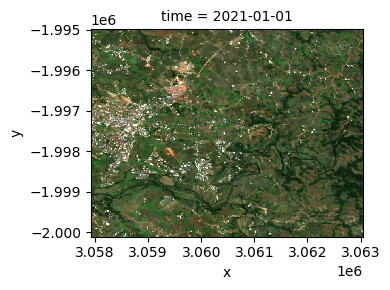

In [12]:
# Extract coordinate system from first item
epsg = items[0].properties["proj:epsg"]

# Convert point from lon/lat to UTM projection
poidf = gpd.GeoDataFrame(crs="OGC:CRS84", geometry=[area_of_interest.centroid]).to_crs(
    epsg
)
geom = poidf.iloc[0].geometry

# Create bounds of the correct size, the model
# requires 512x512 pixels at 10m resolution.
bounds = (geom.x - 2560, geom.y - 2560, geom.x + 2560, geom.y + 2560)

# Retrieve the pixel values, for the bounding box in
# the target projection. In this example we use only
# the RGB and NIR band groups.
stack = stackstac.stack(
    items,
    bounds=bounds,
    snap_bounds=False,
    epsg=epsg,
    resolution=10,
    dtype="float32",
    rescale=False,
    fill_value=0,
    assets=BAND_GROUPS["rgb"] + BAND_GROUPS["nir"],
    resampling=Resampling.nearest,
)

stack = stack.compute()
assert stack.shape == (1, 4, 512, 512)

stack.sel(band=["B04", "B03", "B02"]).plot.imshow(
    row="time", rgb="band", vmin=0, vmax=2000
)

#### Plot the non "cloud-free" composite Sentinel-2 data

/opt/conda/envs/pytorch_custom/lib/python3.10/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


(1, 4, 512, 512)


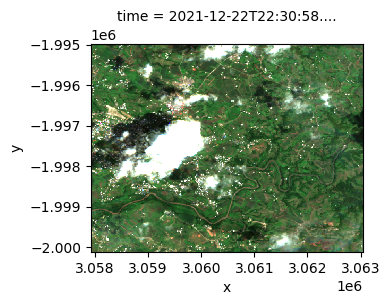

In [13]:
stack_L2A = stackstac.stack(
    items_L2A[0],
    bounds=bounds,
    snap_bounds=False,
    epsg=epsg,
    resolution=10,
    dtype="float32",
    rescale=False,
    fill_value=0,
    assets=BAND_GROUPS_L2A["rgb"] + BAND_GROUPS_L2A["scl"],
    resampling=Resampling.nearest,
)

stack_L2A = stack_L2A.compute()
print(stack_L2A.shape)
assert stack_L2A.shape == (1, 4, 512, 512)

stack_L2A.sel(band=["red", "green", "blue"]).plot.imshow(
    row="time", rgb="band", vmin=0, vmax=2000
)

#### Write the stack to file

In [14]:
outdir = Path("data/minicubes")
outdir.mkdir(exist_ok=True, parents=True)

write = True
if write:
    # Write tile to output dir
    for tile in stack:
        date = str(tile.time.values)[:10]
    
        name = "{dir}/claytile_{date}.tif".format(
            dir=outdir,
            date=date.replace("-", ""),
        )
        tile.rio.to_raster(name, compress="deflate")
    
        with rasterio.open(name, "r+") as rst:
            rst.update_tags(date=date)


In [15]:
# Function to count cloud pixels in a subset

def count_cloud_pixels(subset_scl, cloud_labels):
    cloud_pixels = 0
    for label in cloud_labels:
        cloud_pixels += numpy.count_nonzero(subset_scl == label)
    return cloud_pixels

### Get the geospatial bounds for the 32x32 windows 
We will use the geospatial bounds of the 32x32 windowed subsets ("chunks") to store the patch level embeddings.

In [ ]:
# Define the chunk size for tiling
chunk_size = {'x': 32, 'y': 32}  # Adjust the chunk size as needed

# Tile the data
ds_chunked = stack.chunk(chunk_size)
ds_chunked_L2A = stack_L2A.chunk(chunk_size)

# Get the dimensions of the data array
dims = ds_chunked.dims

# Get the geospatial information from the original dataset
geo_info = ds_chunked.attrs

# Iterate over the chunks and compute the geospatial bounds for each chunk
chunk_bounds = {}

# Iterate over the chunks and compute the cloud count for each chunk
cloud_pcts = {}

# Get the geospatial transform and CRS
transform = ds_chunked.attrs['transform']
crs = ds_chunked.attrs['crs']

for x in range((ds_chunked.sizes['x'] // chunk_size['x']) + 1):
    for y in range((ds_chunked.sizes['y'] // chunk_size['y']) + 1):
        # Compute chunk coordinates
        x_start = x * chunk_size['x']
        y_start = y * chunk_size['y']
        x_end = min(x_start + chunk_size['x'], ds_chunked.sizes['x'])
        y_end = min(y_start + chunk_size['y'], ds_chunked.sizes['y'])
        
        # Compute chunk geospatial bounds
        lon_start, lat_start = transform * (x_start, y_start)
        lon_end, lat_end = transform * (x_end, y_end)
        #print(lon_start, lat_start, lon_end, lat_end, x, y)

        # Store chunk bounds
        chunk_bounds[(x, y)] = {
            'lon_start': lon_start, 'lat_start': lat_start,
            'lon_end': lon_end, 'lat_end': lat_end
        }

        # Extract the subset of the SCL band
        subset_scl = ds_chunked_L2A[:,:,5][:, y_start:y_end, x_start:x_end]
        
        # Count the cloud pixels in the subset
        cloud_pct = count_cloud_pixels(subset_scl, SLC_CLOUD_LABELS)
        
        # Store the cloud percent for this chunk
        cloud_pcts[(x, y)] = cloud_pct

# Print chunk bounds
#for key, value in chunk_bounds.items():
    #print(f"Chunk {key}: {value}")

# Print cloud counts
for key, value in cloud_pcts.items():
    if value > 0:
        print(f"Chunk {key}: Cloud percentage = {value}")

### Generate embeddings for the full or partial inputs
We will generate patch level embeddings averaged over the band groups.

In [ ]:
DATA_DIR = "data/minicubes"
CKPT_PATH = "/home/ubuntu/data/checkpoints/mae_epoch-24_val-loss-0.46.ckpt"

# Load model
multi_model = CLAYModule.load_from_checkpoint(
    CKPT_PATH,
    mask_ratio=0.0,
    band_groups={"rgb": (2, 1, 0), "nir": (3,)},
    bands=4,
    strict=False,  # ignore the extra parameters in the checkpoint
    embeddings_level="group",
)
# Set the model to evaluation mode
multi_model.eval()


# Load the datamodule, with the reduced set of
class ClayDataModuleMulti(ClayDataModule):
    MEAN = [
        1369.03,  # red
        1597.68,  # green
        1741.10,  # blue
        2893.86,  # nir
    ]
    STD = [
        2026.96,  # red
        2011.88,  # green
        2146.35,  # blue
        1917.12,  # nir
    ]


data_dir = Path(DATA_DIR)

dm = ClayDataModuleMulti(data_dir=str(data_dir.absolute()), batch_size=1)
dm.setup(stage="predict")
trn_dl = iter(dm.predict_dataloader())

In [ ]:
embeddings = []
for batch in trn_dl:
    with torch.no_grad():
        # Move data from to the device of model
        batch["pixels"] = batch["pixels"].to(multi_model.device)
        # Pass just the specific band through the model
        batch["timestep"] = batch["timestep"].to(multi_model.device)
        batch["latlon"] = batch["latlon"].to(multi_model.device)

        # Pass pixels, latlon, timestep through the encoder to create encoded patches
        (
            unmasked_patches,
            unmasked_indices,
            masked_indices,
            masked_matrix,
        ) = multi_model.model.encoder(batch)
        print(unmasked_patches.detach().cpu().numpy())

        embeddings.append(unmasked_patches.detach().cpu().numpy())

In [ ]:
print(len(embeddings[0])) # embeddings is a list
print(embeddings[0].shape) # with date and lat/lon
print(embeddings[0][:, :-2, :].shape) # remove date and lat/lon

In [ ]:
# remove date and lat/lon and reshape to disaggregated patches
embeddings_patch = embeddings[0][:, :-2, :].reshape([2,16,16,768]) 

In [21]:
embeddings_patch.shape

(2, 16, 16, 768)

In [22]:
# average over the band groups
embeddings_patch_avg_group = embeddings_patch.mean(axis=0)

In [23]:
embeddings_patch_avg_group.shape

(16, 16, 768)

### Save the patch level embeddings to independent GeoParquet files
Save the patch level embeddings with the matching geospatial bounds and cloud cover percentages from the chunks we computed earlier. We are correlating patch to chunk bounds based on matching index. This assumes the patches and chunks both define 32x32 subsets with zero overlap.

In [ ]:
# Iterate through each patch
for i in range(embeddings_patch_avg_group.shape[0]):
    for j in range(embeddings_patch_avg_group.shape[1]):
        embeddings_output_patch = embeddings_patch_avg_group[i, j]

        item_ = [element for element in list(chunk_bounds.items()) if element[0] == (i,j)]
        box_ = [item_[0][1]['lon_start'], item_[0][1]['lat_start'],item_[0][1]['lon_end'], item_[0][1]['lat_end']]
        cloud_pct_ = [element for element in list(cloud_pcts.items()) if element[0] == (i,j)]
        source_url = batch["source_url"]
        date = batch["date"]
        data = {
            "source_url": batch["source_url"][0],
            "date": pd.to_datetime(arg=date, format="%Y-%m-%d").astype(dtype="date32[day][pyarrow]"),
            "embeddings": [numpy.ascontiguousarray(embeddings_output_patch)],
            "cloud_cover": cloud_pct_[0][1]
        }
        
        # Define the bounding box as a Polygon (xmin, ymin, xmax, ymax)
        # The box_ list is encoded as [bottom left x, bottom left y, top right x, top right y]
        box_emb = shapely.geometry.box(box_[0], box_[1], box_[2], box_[3])
        
        # Create the GeoDataFrame
        gdf = gpd.GeoDataFrame(data, geometry=[box_emb], crs=f"EPSG:{epsg}")
        
        # Reproject to WGS84 (lon/lat coordinates)
        gdf = gdf.to_crs(epsg=4326)

        outpath = f"data/embeddings/{batch['source_url'][0].split('/')[-1][:-4]}_{i}_{j}.gpq"
        print(outpath)
        gdf.to_parquet(path=outpath, compression="ZSTD", schema_version="1.0.0")
        print(
            f"Saved {len(gdf)} rows of embeddings of "
            f"shape {gdf.embeddings.iloc[0].shape} to {outpath}"
        )

### Similarity search on the patch embedding level
We will use reference lon,lat points from the ground truth mining extraction data to define a filtered search where a point maps to its overlapping patch, and that patch is used to find similar patches (aka potential new mining extraction sites).

In [25]:
db = lancedb.connect("embeddings")

In [26]:
# Data for DB table
data = []
# Dataframe to find overlaps within
gdfs = []
for emb in glob.glob("data/embeddings/*.gpq"):
    gdf = gpd.read_parquet(emb)
    gdf["year"] = gdf.date.dt.year
    gdf["tile"] = gdf["source_url"].apply(lambda x: Path(x).stem.rsplit("/")[-1].rsplit("_")[0])
    gdf["idx"] = '_'.join(emb.split("/")[-1].split("_")[2:]).replace('.gpq', '')
    gdf["box"] = [box(*geom.bounds) for geom in gdf.geometry]
    gdfs.append(gdf)
    
    for _,row in gdf.iterrows():
        data.append({
            "vector": row["embeddings"],
            "path": row["source_url"],
            "tile": row["tile"],
            "date": row["date"],
            "year": int(row["year"]),
            "cloud_cover": row["cloud_cover"],
            "idx": row["idx"],
            "box": row["box"].bounds,
        })

In [27]:
# Combine patch level geodataframes into one
embeddings_gdf = pd.concat(gdfs, ignore_index=True)

##### (Optional) check on what an embedding's RGB subset looks like

/opt/conda/envs/pytorch_custom/lib/python3.10/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


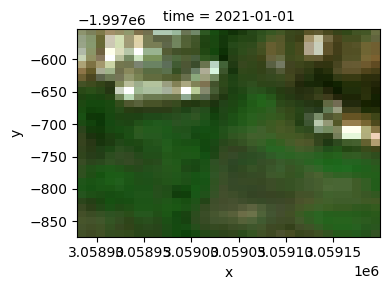

In [28]:
embeddings_gdf_shuffled = embeddings_gdf.sample(frac=1).reset_index(drop=True)

area_of_interest_embedding = embeddings_gdf_shuffled.box.iloc[0] #list(embeddings_gdf.bbox.iloc[0].bounds)

# Extract coordinate system from first item
epsg = items[0].properties["proj:epsg"]

# Convert point from lon/lat to UTM projection
box_embedding = gpd.GeoDataFrame(crs="OGC:CRS84", geometry=[area_of_interest_embedding]).to_crs(
    epsg
)
geom_embedding = box_embedding.iloc[0].geometry

# Create bounds of the correct size, the model
# requires 512x512 pixels at 10m resolution.

# Retrieve the pixel values, for the bounding box in
# the target projection. In this example we use only
# the RGB and NIR band groups.
stack_embedding = stackstac.stack(
    items,
    bounds=geom_embedding.bounds,
    snap_bounds=False,
    epsg=epsg,
    resolution=10,
    dtype="float32",
    rescale=False,
    fill_value=0,
    assets=BAND_GROUPS["rgb"] + BAND_GROUPS["nir"],
    resampling=Resampling.nearest,
)

stack_embedding = stack_embedding.compute()
#assert stack_embedding.shape == (1, 4, 512, 512)

stack_embedding.sel(band=["B04", "B03", "B02"]).plot.imshow(
    row="time", rgb="band", vmin=0, vmax=2000
)

#### Instantiate a dedicated DB table

In [29]:
db.drop_table("clay-v001")
db.table_names()

[]

In [ ]:
tbl = db.create_table("clay-v001", data=data, mode="overwrite")

In [31]:
v = tbl.head(1).to_pandas()["vector"].values[0]

#### Find the intersections of ground truth mining extraction points with patch embeddings

In [32]:
# Function to check if a point intersects with a bounding box
def check_intersection(row):
    return point.intersects(row['box'])

intersecting_rows_ = []
for i, row in mrd_mining.iterrows():
    # Create a Point geometry from the latitude and longitude
    point = Point(row.x, row.y)
    #print(point)

    # Apply the function to each row of the DataFrame
    intersects = embeddings_gdf.apply(check_intersection, axis=1)

    # Get the rows where the point intersects with the bounding box
    intersecting_rows = embeddings_gdf[intersects]
    if not intersecting_rows.empty:
        #print(intersecting_rows)
        intersecting_rows_.append(intersecting_rows)

In [33]:
# Number of intersections in our AOI (which depicts a cluster)
len(intersecting_rows_)

11

#### Set up a filtered search to find 10 patches similar to the first intersecting patch

In [34]:
chips = [
    {"tile": "claytile", "idx": f"{intersecting_rows_[0].idx.values[0]}", "year": 2021},
]
filter = " OR ".join(
        [f"(tile == '{chip['tile']}' AND idx == '{chip['idx']}') AND year == {chip['year']}" for chip in chips]
    )

v = tbl.search().where(filter).to_pandas().iloc[0]["vector"]

In [35]:
result = tbl.search(query=v).limit(10).to_pandas()

In [41]:
#result.head(10)
result.columns

Index(['vector', 'path', 'tile', 'date', 'year', 'cloud_cover', 'idx', 'box',
       '_distance'],
      dtype='object')

### Plot similar patches

In [37]:
def plot(df, cols=10):
    fig, axs = plt.subplots(1, cols, figsize=(20, 10))

    row_0 = df.iloc[0]
    path = row_0["path"]
    chip = rasterio.open(path)
    tile = row_0["tile"]
    width = chip.width
    height = chip.height
    # Define the window size
    window_size = (32, 32)

    idxs_windows = {'idx': [], 'window': []}

    # Iterate over the image in 32x32 windows
    for col in range(0, width, window_size[0]):
        for row in range(0, height, window_size[1]):
            # Define the window
            window = ((row, row + window_size[1]), (col, col + window_size[0]))
            
            # Read the data within the window
            data = chip.read(window=window)
            
            # Get the index of the window
            index = (col // window_size[0], row // window_size[1])
            
            # Process the window data here
            # For example, print the index and the shape of the window data
            #print("Index:", index)
            #print("Window Shape:", data.shape)

            idxs_windows['idx'].append('_'.join(map(str, index)))
            idxs_windows['window'].append(data)
            
    #print(idxs_windows)
    
    for ax, (_, row) in zip(axs.flatten(), df.iterrows()):
        idx = row["idx"]
        # Find the corresponding window based on the idx
        window_index = idxs_windows['idx'].index(idx)
        window_data = idxs_windows['window'][window_index]
        #print(window_data.shape)
        subset_img = numpy.clip((window_data.transpose(1,2,0)[:, :, :3]/10_000) * 3, 0,1)
        ax.imshow(subset_img)
        ax.set_title(f"{tile}/{idx}")
        ax.set_axis_off()
    plt.tight_layout()
    fig.savefig("similar.png")

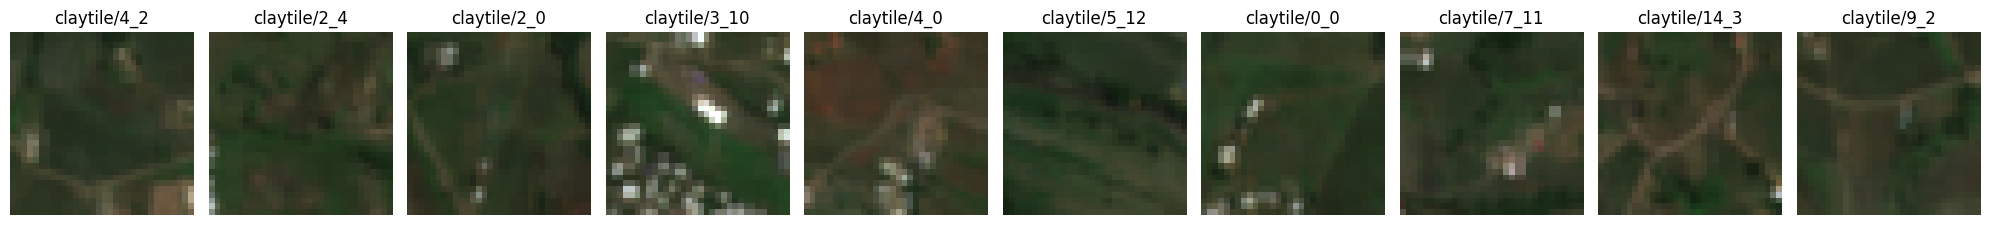

In [38]:
plot(result)

#### Visualize the area of interest with the ground truth mining points and similar patches

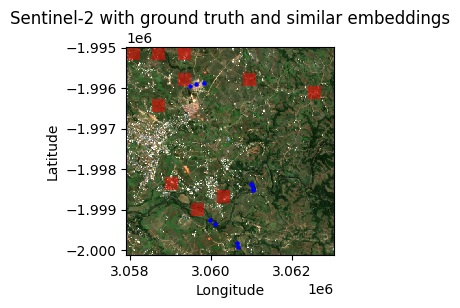

In [39]:
# Make a geodataframe of the search results
result_boxes = [Polygon([(bbox[0], bbox[1]), (bbox[2], bbox[1]), (bbox[2], bbox[3]), (bbox[0], bbox[3])]) for bbox in result['box']]
result_gdf = gpd.GeoDataFrame(result, geometry=result_boxes)
result_gdf.crs = "EPSG:4326"

# Plot the AOI in RGB
stack.sel(band=["B04", "B03", "B02"]).plot.imshow(row="time", rgb="band", vmin=0, vmax=2000)

# Overlay the bounding boxes of the patches identified from the similarity search
result_gdf.to_crs(epsg).plot(ax=plt.gca(), color='red', alpha=0.5)
# Overlay the ground truth quarry points
mrd_mining.to_crs(epsg).cx[bounds[0]:bounds[2], bounds[1]:bounds[3]].plot(ax=plt.gca(), color='blue', markersize=5)

# Set plot title and labels
plt.title('Sentinel-2 with ground truth and similar embeddings')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()